In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
# import plotly.graph_objs as go
# import plotly.plotly as py
# import cufflinks
from IPython.core.interactiveshell import InteractiveShell
# import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

Using TensorFlow backend.


In [3]:
df=pd.read_csv("faqs.csv", sep=';', engine='python')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 2 columns):
cust_inquiry    217 non-null object
label           217 non-null object
dtypes: object(2)
memory usage: 3.5+ KB


# Cleaning Data

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#Basic text preprocessing
def clean_text(text):
    
    ## convert words to lower case 
    text = text.lower()
    
    ## replace contractions
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'m", " am ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"what's", "what is ", text)
    
    ## remove special characters and puntuaction
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = text.split()
    
    ## remove stop words and words with less than 3 letters
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
   
    ## lemmatize words based on verb 
    lema = WordNetLemmatizer()
    lema_words = [lema.lemmatize(word, pos="v") for word in text]
    text = " ".join(lema_words)
    
    return text

In [6]:
from sklearn.utils import shuffle
df = shuffle(df)
sentences=df["cust_inquiry"]

df['cleanText']=sentences.apply(clean_text)


#targets=pd.get_dummies(df["label"])

df.head()

,cust_inquiry,label,cleanText
86,What happens if the Gift Voucher I bought hasn...,payment_voucher,happen gift voucher buy receive
29,My return label is missing. How do I replace it?,return_refund,return label miss replace
119,Can I have my order delivered to a PO Box addr...,delivery,order deliver box address
140,How do I return my order from Denmark?,return_refund,return order denmark
174,"I'd like to close my account with , what shoul...",technical,would like close account


In [34]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 200
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleanText'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 310 unique tokens.


In [35]:
X = tokenizer.texts_to_sequences(df['cleanText'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (217, 250)


In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,targets, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(195, 250) (195, 7)
(22, 250) (22, 7)


# Creating Model

In [37]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 25
batch_size = 45

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 175 samples, validate on 20 samples
Epoch 1/25
175/175 [==============================] - 7s 41ms/step - loss: 1.9379 - acc: 0.2057 - val_loss: 1.9254 - val_acc: 0.1000
Epoch 2/25
175/175 [==============================] - 4s 24ms/step - loss: 1.9031 - acc: 0.1943 - val_loss: 1.9113 - val_acc: 0.1000
Epoch 3/25
175/175 [==============================] - 4s 25ms/step - loss: 1.8601 - acc: 0.2057 - val_loss: 1.9055 - val_acc: 0.1000
Epoch 4/25
175/175 [==============================] - 4s 25ms/step - loss: 1.8617 - acc: 0.1943 - val_loss: 1.8593 - val_acc: 0.1500
Epoch 5/25
175/175 [==============================] - 4s 25ms/step - loss: 1.8370 - acc: 0.2857 - val_loss: 1.8370 - val_acc: 0.1000
Epoch 6/25
175/175 [==============================] - 4s 25ms/step - loss: 1.8243 - acc: 0.2743 - val_loss: 1.8281 - val_acc: 0.1000
Epoch 7/25
175/175 [==============================] - 4s 24ms/step - loss: 1.8188 - acc: 0.2743 - val_loss: 1.8340 - val_acc: 0.1000
Epoch 8/25
175/175 [====

In [11]:
epochs = 15
batch_size = 45

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 175 samples, validate on 20 samples
Epoch 1/15
175/175 [==============================] - 3s 16ms/step - loss: 1.3785 - acc: 0.6743 - val_loss: 1.6496 - val_acc: 0.4500
Epoch 2/15
175/175 [==============================] - 3s 17ms/step - loss: 1.2680 - acc: 0.7029 - val_loss: 1.5766 - val_acc: 0.4500
Epoch 3/15
175/175 [==============================] - 3s 16ms/step - loss: 1.1440 - acc: 0.6800 - val_loss: 1.4852 - val_acc: 0.4000
Epoch 4/15
175/175 [==============================] - 3s 16ms/step - loss: 1.0527 - acc: 0.7657 - val_loss: 1.4378 - val_acc: 0.4500
Epoch 5/15
175/175 [==============================] - 3s 15ms/step - loss: 0.9257 - acc: 0.7314 - val_loss: 1.4306 - val_acc: 0.4500
Epoch 6/15
175/175 [==============================] - 3s 15ms/step - loss: 0.8372 - acc: 0.7543 - val_loss: 1.3601 - val_acc: 0.4500
Epoch 7/15
175/175 [==============================] - 3s 16ms/step - loss: 0.7044 - acc: 0.8057 - val_loss: 1.3345 - val_acc: 0.4500
Epoch 8/15
175/175 [====

# Testing Accuracy

In [12]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

22/22 [==============================] - 0s 4ms/step
Test set
  Loss: 1.231
  Accuracy: 0.636


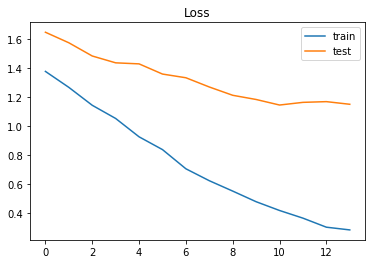

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

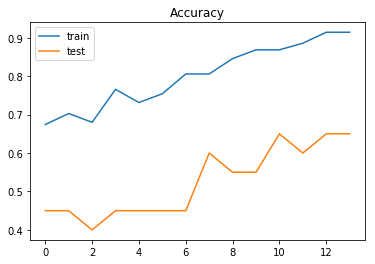

In [14]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# Predicting a Sample Question

In [16]:
df['label'].value_counts()

delivery           43
payment_voucher    40
return_refund      36
technical          35
product_stock      32
order              26
sizing              5
Name: label, dtype: int64

In [17]:
import joblib


In [18]:
joblib.dump(model,'LSTM-model')

['LSTM-model']

In [42]:
modellstm=joblib.load('LSTM-model')

In [45]:
new_faq = ['What delivery options are available?']
seq = tokenizer.texts_to_sequences(new_faq)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = modellstm.predict(padded)
labels = ['delivery','order','payment_voucher','product_stock','return_refund','sizing','technical']
print(pred, labels[np.argmax(pred)])

[[0.7263112  0.23431356 0.00912665 0.00399645 0.02163862 0.0033176
  0.00129609]] delivery
